In [1]:
#!pip install --upgrade protobuf => Run this if you get any protobuf errors. You might need to upgrade tf and keras

## Library Imports

In [2]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

## Data Extraction and Pre-processing

In [3]:
# The labels are stored in text files, while the actual images are in png format. This chunk first gets all the data(info from
# the text files and image paths) and stores it in tabular format
labels = []
img_names = []
img_paths = []
gender = []
path = '../data/NistFormatted/'
for file in os.listdir(path):
    if file.endswith('.txt'):
        with open(os.path.join(path, file), 'r') as t:
            content = t.readlines()
            gender.append(content[0].rsplit(' ')[1][0])
            img_name = content[2].rsplit(' ')[1][:-4] + '.png'
            img_paths.append(os.path.join(path,img_name))
            img_names.append(img_name)
            labels.append((content[1].rsplit(' ')[1][0]))           
df = pd.DataFrame()
df['IMAGE PATH'] = img_paths
df['IMAGE NAME'] = img_names
df['LABEL'] = labels
df['GENDER'] = gender

In [4]:
df.head()

,IMAGE PATH,IMAGE NAME,LABEL,GENDER
0,../data/NistFormatted/f0001_01.png,f0001_01.png,W,M
1,../data/NistFormatted/f0002_05.png,f0002_05.png,R,M
2,../data/NistFormatted/f0003_10.png,f0003_10.png,L,F
3,../data/NistFormatted/f0004_05.png,f0004_05.png,R,M
4,../data/NistFormatted/f0005_03.png,f0005_03.png,A,M


In [5]:
#Classes to integer mapping
classes = list(np.unique(labels))
map_classes = dict(zip(classes, [t for t in range(len(classes))]))
print(map_classes)
df['MAPPED LABELS'] = [map_classes[i] for i in df['LABEL']]
#df = df.sample(frac = 1) #To randomly shuffle the data
#Saving the dataset in-case of future use
directory = 'DataNist1.0.0'
if not os.path.exists(directory):
    os.makedirs(directory)
df.to_csv('DataNist1.0.0/dataset.csv')
df.head()

{'A': 0, 'L': 1, 'R': 2, 'T': 3, 'W': 4}


,IMAGE PATH,IMAGE NAME,LABEL,GENDER,MAPPED LABELS
0,../data/NistFormatted/f0001_01.png,f0001_01.png,W,M,4
1,../data/NistFormatted/f0002_05.png,f0002_05.png,R,M,2
2,../data/NistFormatted/f0003_10.png,f0003_10.png,L,F,1
3,../data/NistFormatted/f0004_05.png,f0004_05.png,R,M,2
4,../data/NistFormatted/f0005_03.png,f0005_03.png,A,M,0


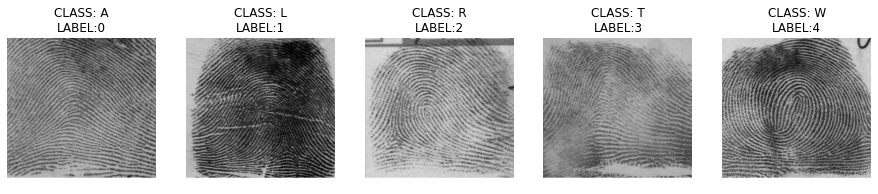

In [6]:
dim = len(classes)
fig,axes = plt.subplots(1,dim) 
fig.subplots_adjust(0,0,2,2)
for idx, i in enumerate(classes):
    # Gets random example from each class
    dum = df[df['LABEL'] == i]
    random_num = random.choice(dum.index)
    label = df.loc[random_num]['LABEL']
    axes[idx].imshow(cv2.imread(df.loc[random_num]['IMAGE PATH']))
    axes[idx].set_title("CLASS: "+label +"\n" +  "LABEL:"+str(map_classes[label]))
    axes[idx].axis('off')

In [7]:
# We don't need the gender for now
X_data = df['IMAGE PATH']
y_data = df['MAPPED LABELS']
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, shuffle=True, test_size=0.02,stratify=y_data, random_state=42)


# Currently the df only has the image paths. We need to read the image data.

# Just iterates through the paths, reads the data and stores in array
def image_data_getter(X, Y):
    X_result = []
    Y_result = []
    for i in X:
        X_result.append(cv2.imread(i))
    for i in Y:
        Y_result.append(i)
    #One hot encoding the oridnal
    Y_result = keras.utils.to_categorical(Y_result, 5)
    return np.array(X_result), np.array(Y_result)

X_train_arr, Y_train_arr = image_data_getter(X_train, Y_train)
X_test_arr, Y_test_arr = image_data_getter(X_test, Y_test)

print(f"Total number of Images: {len(X_data)}")
print(f"Number of Training Images: {len(X_train_arr)}")
print(f"Number of Test Images: {len(X_test_arr)}")
print(f"Shape of a single image: {X_train_arr[0].shape}")

Total number of Images: 4000
Number of Training Images: 3920
Number of Test Images: 80
Shape of a single image: (512, 512, 3)


In [8]:
#Saving the test df so that it can be used later with the saved models
test_df = pd.concat([Y_test, X_test], axis=1)
test_df.columns = ['MAPPED LABELS', 'IMAGE PATH']
test_df.to_csv('DataNist1.0.0/test_df.csv')

## Model Architecture

In [9]:
model = keras.Sequential(
    [
        layers.Conv2D(32, input_shape=(512,512,3),padding="same",kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3),padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3),padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3),padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(5, activation="softmax",kernel_regularizer='l1_l2'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 64)        0

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Training

In [11]:
%%time
#Training
model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X_train_arr, y=Y_train_arr, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
49/49 [==============================] - 608s 11s/step - loss: 6.6318 - accuracy: 0.2152 - val_loss: 4.7475 - val_accuracy: 0.2717
Epoch 2/20
49/49 [==============================] - 543s 11s/step - loss: 4.1611 - accuracy: 0.2526 - val_loss: 3.6223 - val_accuracy: 0.2793
Epoch 3/20
49/49 [==============================] - 841s 17s/step - loss: 3.0612 - accuracy: 0.4432 - val_loss: 2.4483 - val_accuracy: 0.6148
Epoch 4/20
49/49 [==============================] - 974s 20s/step - loss: 2.2151 - accuracy: 0.6317 - val_loss: 1.9296 - val_accuracy: 0.6709
Epoch 5/20
49/49 [==============================] - 682s 14s/step - loss: 1.7344 - accuracy: 0.6958 - val_loss: 1.4794 - val_accuracy: 0.7283
Epoch 6/20
49/49 [==============================] - 774s 16s/step - loss: 1.3966 - accuracy: 0.7296 - val_loss: 1.2093 - val_accuracy: 0.7564
Epoch 7/20
49/49 [==============================] - 774s 16s/step - loss: 1.1506 - accuracy: 0.7643 - val_loss: 0.9854 - val_accuracy: 0.7997
Epoch 

## Saving model and training history

In [12]:
#Saving model
from tensorflow.keras.models import save_model
model.save('DataNist1.0.0/FPMR_CNN_Nist_1.0.0')
with open('DataNist1.0.0/FPMR_CNN_Nist_1.0.0_history.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)

INFO:tensorflow:Assets written to: DataNist1.0.0/FPMR_CNN_Nist_1.0.0\assets


INFO:tensorflow:Assets written to: DataNist1.0.0/FPMR_CNN_Nist_1.0.0\assets


<IPython.core.display.Javascript object>

## Using the saved model

In [1]:
import pickle
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('DataNist1.0.0/FPMR_CNN_Nist_1.0.0')

# Load the training history
with open('DataNist1.0.0/FPMR_CNN_Nist_1.0.0_history.pkl', 'rb') as history_file:
    loaded_history = pickle.load(history_file)

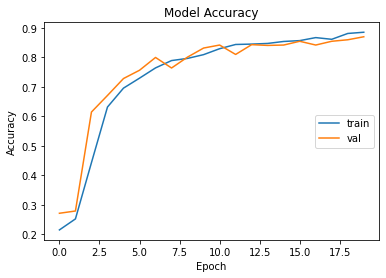

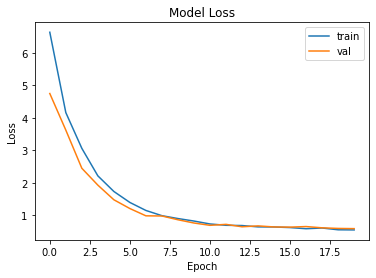

In [3]:
plt.plot(loaded_history['accuracy'])
plt.plot(loaded_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='center right')
plt.show()

plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
break

## Predicting on test set

In [4]:
testing_df = pd.read_csv('DataNist1.0.0/test_df.csv')

In [7]:
testing_df

,Unnamed: 0,MAPPED LABELS,IMAGE PATH
0,2989,1,../data/NistFormatted/s0990_09.png
1,1952,3,../data/NistFormatted/f1953_03.png
2,3321,1,../data/NistFormatted/s1322_09.png
3,2685,1,../data/NistFormatted/s0686_10.png
4,524,4,../data/NistFormatted/f0525_02.png
...,...,...,...
75,1448,3,../data/NistFormatted/f1449_07.png
76,935,2,../data/NistFormatted/f0936_01.png
77,1406,4,../data/NistFormatted/f1407_04.png
78,541,0,../data/NistFormatted/f0542_07.png


In [8]:
image_data = np.expand_dims(cv2.imread(testing_df['IMAGE PATH'].loc[79]), axis=0)

In [9]:
np.argmax(loaded_model.predict(image_data))

1/1 [==============================] - 0s 242ms/step


1

In [10]:
#Testing the testing dataset
results = []
for i in range(0, len(testing_df)):
    image_data = np.expand_dims(cv2.imread(testing_df['IMAGE PATH'].loc[i]), axis=0)
    results.append(np.argmax(loaded_model.predict(image_data)))

1/1 [==============================] - 0s 80ms/step


In [11]:
true_vals = testing_df['MAPPED LABELS'].tolist()

In [12]:
def find_differing_indices(list1, list2):
    differing_indices = []
    for index, (item1, item2) in enumerate(zip(list1, list2)):
        if item1 != item2:
            differing_indices.append(index)
    return differing_indices
differences = find_differing_indices(true_vals, results)
print("Differing indices:", differences)

Differing indices: [27, 38, 40, 42, 46, 50, 58, 64, 75]


In [13]:
print("Test Accuracy: ", (1-(len(differences)/len(results)))*100)

Test Accuracy:  88.75


In [ ]:
fig,axes = plt.subplots(5,5) 
fig.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        num = random.randint(0,len(X_test_arr)-1)
        display_image = X_test_arr[num].squeeze(0)
        image = X_test_arr[num]
        predicted_prob = model.predict(image)
        predicted_class = np.argmax(predicted_prob)
        ground_truth =classes[Y_test_arr.iloc[num]]
        axes[i,j].imshow(display_image)
        axes[i,j].imshow(display_image)
        if(classes[predicted_class] != classes[y_test.iloc[num]]):
            t = 'PREDICTED {} \n GROUND TRUTH[{}]'.format(classes[predicted_class], classes[y_test.iloc[num]])
            axes[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[CORRECT] {}'.format(classes[predicted_class]) 
            axes[i,j].set_title(t)
        axes[i,j].axis('off')